In [1]:
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
import cv2, math, glob, os
import matplotlib.pyplot as plt
import os
from keras.utils import load_img, img_to_array
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import seaborn as sns

In [3]:
!nvidia-smi

Wed Mar  8 06:27:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the images directories
path = "/content/drive/MyDrive/rawData"
print(os.listdir(path))

['adenocarcinoma', 'normal', 'large.cell.carcinoma', 'squamous.cell.carcinoma']


In [6]:
from cv2 import cvtColor

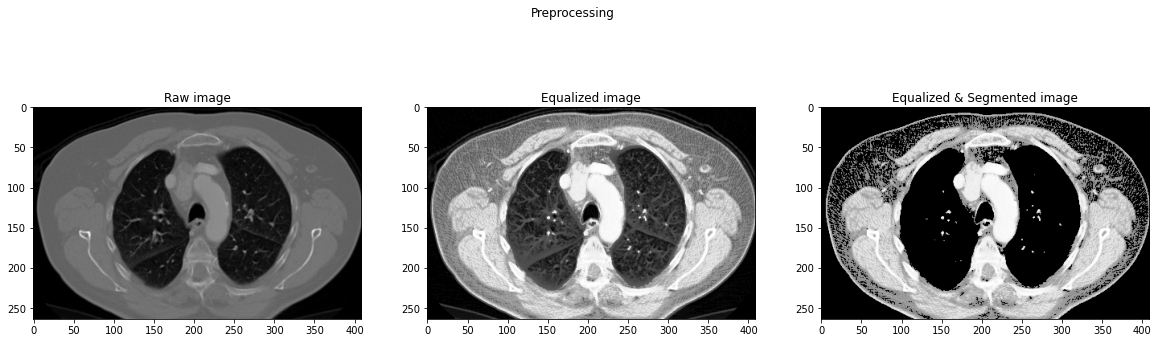

In [ ]:
img = cv2.imread('/content/drive/MyDrive/rawData/adenocarcinoma/adenocarcinoma1.png', 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [ ]:
print(os.getcwd(), os.listdir())
DIR = './rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = './data'

/content ['.config', 'drive', 'sample_data']


In [ ]:
import os
import cv2

DIR = "rawData"
DEST_DIR = "processedData"

if not os.path.exists(DEST_DIR):
    os.makedirs(os.path.join(DEST_DIR, "adenocarcinoma"))
    os.makedirs(os.path.join(DEST_DIR, "largecellcarcinoma"))
    os.makedirs(os.path.join(DEST_DIR, "squamouscellcarcinoma"))
    os.makedirs(os.path.join(DEST_DIR, "normal"))

CATS = ["/content/processedData/adenocarcinoma", "/content/drive/MyDrive/rawData/large.cell.carcinoma", "/content/drive/MyDrive/rawData/squamous.cell.carcinoma", "/content/drive/MyDrive/rawData/normal"]

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = os.path.join(DEST_DIR, "normal", image)
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('rawData', 'processedData')
            imgDest = imgDest.replace(category, category.lower())
            cv2.imwrite(imgDest, segmentedImage)

print("Processed data directory created successfully at", DEST_DIR)


In [ ]:
FINAL_DIR = '/content/drive/MyDrive/data'
DEST_DIR = "/content/drive/MyDrive/preprocessedData"
splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2)) 

In [7]:
BATCH_SIZE=4


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,                  
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [8]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 32)

Found 1086 images belonging to 4 classes.


In [9]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data/val',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 170 images belonging to 4 classes.


In [10]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 519 images belonging to 4 classes.


In [11]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name='val_accuracy'),
      # tf.keras.metrics.SparseCategoricalAccuracy(name='val_Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),  
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

In [12]:
img_data =[]
predict_labels =[]
img_ext=['png']

In [13]:
#for AdenoCarcinoma
files_name = []
image_dir ='/content/drive/MyDrive/data/train/adenocarcinoma/'
[files_name.extend(glob.glob(image_dir +'*.' + e)) for e in img_ext]
display(files_name)

img_data.extend([cv2.imread(file) for file in files_name])
display(img_data)

predict_labels.extend(['AdenoCarcinoma' for file in files_name])
display(predict_labels)


['/content/drive/MyDrive/data/train/adenocarcinoma/000109 (2).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000114 (5).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000108 (3).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000112 (2).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000109 (5).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000109 (4).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000113 (7).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000132 (7).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000158 (3).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000134.png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000144 (2).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000143 (6).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000146 (6).png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/000155.png',
 '/content/drive/MyDrive/data/train/adenocarcinoma/00016

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[10, 10, 10],
         [14, 14, 14],
         [19, 19, 19],
         ...,
         [ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0]]

['AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarci

In [14]:
#for LargeCellCarcinoma
files_name = []
image_dir ='/content/drive/MyDrive/data/train/largecellcarcinoma/'
[files_name.extend(glob.glob(image_dir +'*.' + e)) for e in img_ext]
display(files_name)

img_data.extend([cv2.imread(file) for file in files_name])
display(img_data)

predict_labels.extend(['LargeCellCarcinoma' for file in files_name])
display(predict_labels)

['/content/drive/MyDrive/data/train/largecellcarcinoma/000016 (3).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000095.png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000055 (4).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000080.png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000055 (3).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000097.png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000068 (4).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000059 (3).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000076 (3).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000058 (4).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000018 (2).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000033 (3).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000059 (4).png',
 '/content/drive/MyDrive/data/train/largecellcarcinoma/000021.png',
 '/conte

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[10, 10, 10],
         [14, 14, 14],
         [19, 19, 19],
         ...,
         [ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0]]

['AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarci

In [15]:
#for SquamousCellCarcinoma
files_name = []
image_dir ='/content/drive/MyDrive/data/train/squamouscellcarcinoma/'
[files_name.extend(glob.glob(image_dir +'*.' + e)) for e in img_ext]
display(files_name)

img_data.extend([cv2.imread(file) for file in files_name])
display(img_data)

predict_labels.extend(['SquamousCellCarcinoma' for file in files_name])
display(predict_labels)

['/content/drive/MyDrive/data/train/squamouscellcarcinoma/000083 (7).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000083 (2).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000120 (2).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000079 (5).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000077 (2).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000065 (7).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000081 (3).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000051 (3).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000075.png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000032.png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000057 (3).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000050 (2).png',
 '/content/drive/MyDrive/data/train/squamouscellcarcinoma/000056 (7).png',
 '/content/drive/MyDrive/data/tra

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[10, 10, 10],
         [14, 14, 14],
         [19, 19, 19],
         ...,
         [ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0]]

['AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarci

In [16]:
#for Normal
files_name = []
image_dir ='/content/drive/MyDrive/data/train/normal/'
[files_name.extend(glob.glob(image_dir +'*.' + e)) for e in img_ext]
display(files_name)

img_data.extend([cv2.imread(file) for file in files_name])
display(img_data)

predict_labels.extend(['Normal' for file in files_name])
display(predict_labels)

['/content/drive/MyDrive/data/train/normal/10 - Copy.png',
 '/content/drive/MyDrive/data/train/normal/12 (2) - Copy.png',
 '/content/drive/MyDrive/data/train/normal/13 (2).png',
 '/content/drive/MyDrive/data/train/normal/10.png',
 '/content/drive/MyDrive/data/train/normal/11 - Copy.png',
 '/content/drive/MyDrive/data/train/normal/11 - Copy - Copy.png',
 '/content/drive/MyDrive/data/train/normal/11 - Copy (3).png',
 '/content/drive/MyDrive/data/train/normal/12 (2).png',
 '/content/drive/MyDrive/data/train/normal/13 - Copy (2).png',
 '/content/drive/MyDrive/data/train/normal/12.png',
 '/content/drive/MyDrive/data/train/normal/10 - Copy (3).png',
 '/content/drive/MyDrive/data/train/normal/13 - Copy (3).png',
 '/content/drive/MyDrive/data/train/normal/12 - Copy (2).png',
 '/content/drive/MyDrive/data/train/normal/11.png',
 '/content/drive/MyDrive/data/train/normal/10 - Copy - Copy.png',
 '/content/drive/MyDrive/data/train/normal/11 - Copy (2) - Copy.png',
 '/content/drive/MyDrive/data/trai

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[10, 10, 10],
         [14, 14, 14],
         [19, 19, 19],
         ...,
         [ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0]]

['AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarcinoma',
 'AdenoCarci

In [17]:
img_size = (256,256)
img_data_new = np.array([cv2.resize(i,img_size, interpolation = cv2.INTER_AREA)for i in img_data])
display(img_data_new)

array([[[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]],


       [[[12, 12, 12],
         [17, 17, 17],
         [18, 

In [18]:
prediction_class_label = np.array(predict_labels)
prediction_class_label

array(['AdenoCarcinoma', 'AdenoCarcinoma', 'AdenoCarcinoma', ...,
       'Normal', 'Normal', 'Normal'], dtype='<U21')

In [19]:
img_data_LR =[np.fliplr(img_data_new[i]) for i in range(len(img_data_new))]
prediction_class_label_LR =[prediction_class_label[i] for i in range(len(prediction_class_label))]

In [20]:
new_img_data = np.concatenate([img_data_new, img_data_LR])
new_prediction_class_label = pd.get_dummies(np.array(np.concatenate([prediction_class_label, prediction_class_label_LR])))

In [21]:
new_prediction_class_label

AdenoCarcinoma  LargeCellCarcinoma  Normal  SquamousCellCarcinoma
0                  1                   0       0                      0
1                  1                   0       0                      0
2                  1                   0       0                      0
3                  1                   0       0                      0
4                  1                   0       0                      0
...              ...                 ...     ...                    ...
2125               0                   0       1                      0
2126               0                   0       1                      0
2127               0                   0       1                      0
2128               0                   0       1                      0
2129               0                   0       1                      0

[2130 rows x 4 columns]

In [22]:
from sklearn.model_selection import train_test_split
XX = new_img_data
YY = new_prediction_class_label
rr, cc = img_size
cc

256

In [23]:
XX.shape

(2130, 256, 256, 3)

In [24]:
YY.shape

(2130, 4)

In [25]:
model_base = tf.keras.applications.MobileNet(input_shape=(256,256,3), include_top= False)

for layer in model_base.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(model_base)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(4,activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)


17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 8, 8, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                2097184   
                                                         

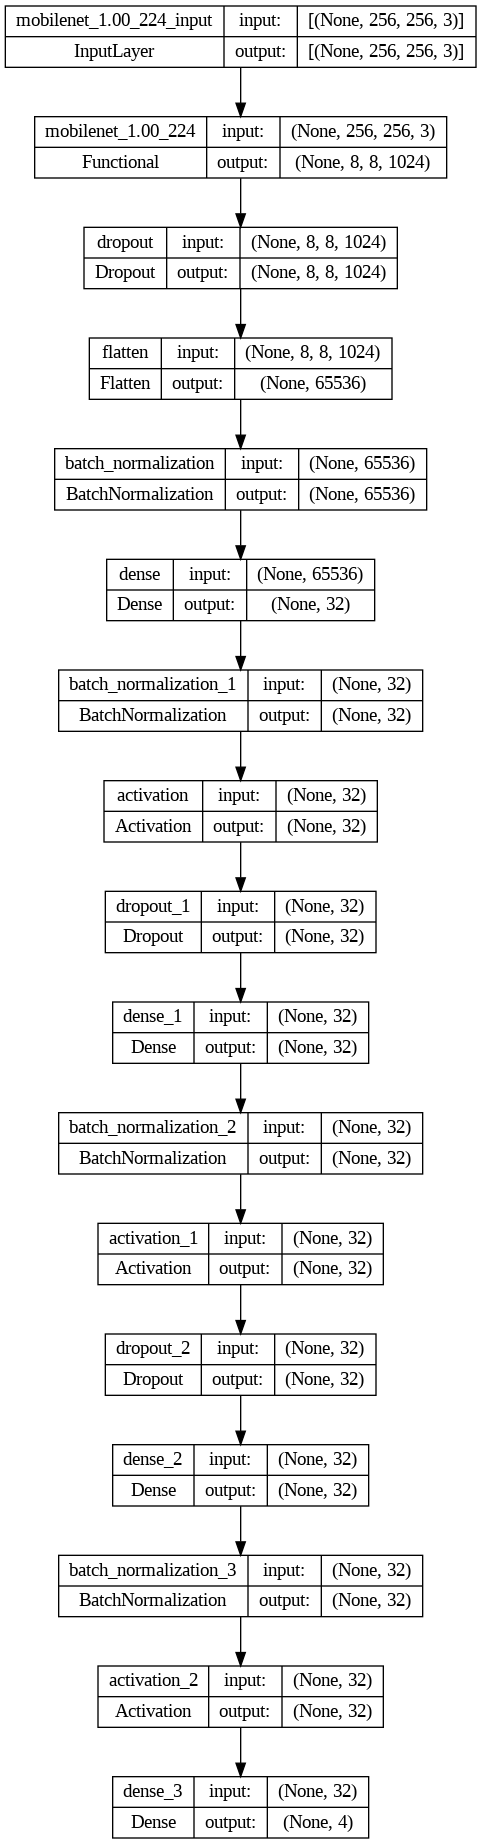

In [26]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True)
Image(filename='model.png')

In [27]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

history = model.fit(x=XX,y=YY,epochs = 50,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/50
66/67 [============================>.] - ETA: 0s - loss: 1.2322 - Accuracy: 0.7699 - val_accuracy: 0.4332 - Precision: 0.6585 - Recall: 0.1652 - AUC: 0.6983 - F1: 0.2600

67/67 [==============================] - 19s 51ms/step - loss: 1.2311 - Accuracy: 0.7700 - val_accuracy: 0.4338 - Precision: 0.6586 - Recall: 0.1657 - AUC: 0.6990 - F1: 0.2611 - lr: 0.0010
Epoch 2/50
66/67 [============================>.] - ETA: 0s - loss: 0.9644 - Accuracy: 0.8151 - val_accuracy: 0.6084 - Precision: 0.8198 - Recall: 0.3338 - AUC: 0.8496 - F1: 0.4710

67/67 [==============================] - 4s 53ms/step - loss: 0.9647 - Accuracy: 0.8151 - val_accuracy: 0.6075 - Precision: 0.8186 - Recall: 0.3347 - AUC: 0.8492 - F1: 0.4722 - lr: 0.0010
Epoch 3/50
66/67 [============================>.] - ETA: 0s - loss: 0.8031 - Accuracy: 0.8477 - val_accuracy: 0.6927 - Precision: 0.8686 - Recall: 0.4602 - AUC: 0.9031 - F1: 0.5987

67/67 [==============================] - 4s 53ms/step - loss: 0.8030 - Accuracy: 0.8475 - val_accuracy: 0.6925 - Precision: 0.8674 - Recall: 0.4606 - AUC: 0.9030 - F1: 0.5987 - lr: 0.0010
Epoch 4/50
66/67 [============================>.] - ETA: 0s - loss: 0.6318 - Accuracy: 0.8842 - val_accuracy: 0.7737 - Precision: 0.8852 - Recall: 0.6170 - AUC: 0.9435 - F1: 0.7241

67/67 [==============================] - 4s 55ms/step - loss: 0.6330 - Accuracy: 0.8839 - val_accuracy: 0.7732 - Precision: 0.8842 - Recall: 0.6164 - AUC: 0.9431 - F1: 0.7229 - lr: 0.0010
Epoch 5/50
66/67 [============================>.] - ETA: 0s - loss: 0.5573 - Accuracy: 0.8989 - val_accuracy: 0.7969 - Precision: 0.8812 - Recall: 0.6884 - AUC: 0.9531 - F1: 0.7717

67/67 [==============================] - 3s 50ms/step - loss: 0.5559 - Accuracy: 0.8993 - val_accuracy: 0.7977 - Precision: 0.8818 - Recall: 0.6897 - AUC: 0.9534 - F1: 0.7733 - lr: 0.0010
Epoch 6/50
66/67 [============================>.] - ETA: 0s - loss: 0.4524 - Accuracy: 0.9212 - val_accuracy: 0.8419 - Precision: 0.9017 - Recall: 0.7685 - AUC: 0.9695 - F1: 0.8288

67/67 [==============================] - 3s 50ms/step - loss: 0.4512 - Accuracy: 0.9211 - val_accuracy: 0.8413 - Precision: 0.9019 - Recall: 0.7681 - AUC: 0.9697 - F1: 0.8285 - lr: 0.0010
Epoch 7/50
66/67 [============================>.] - ETA: 0s - loss: 0.4225 - Accuracy: 0.9281 - val_accuracy: 0.8537 - Precision: 0.9039 - Recall: 0.7973 - AUC: 0.9719 - F1: 0.8465

67/67 [==============================] - 3s 51ms/step - loss: 0.4250 - Accuracy: 0.9278 - val_accuracy: 0.8535 - Precision: 0.9036 - Recall: 0.7962 - AUC: 0.9714 - F1: 0.8451 - lr: 0.0010
Epoch 8/50
66/67 [============================>.] - ETA: 0s - loss: 0.3596 - Accuracy: 0.9373 - val_accuracy: 0.8741 - Precision: 0.9103 - Recall: 0.8310 - AUC: 0.9790 - F1: 0.8683

67/67 [==============================] - 4s 55ms/step - loss: 0.3626 - Accuracy: 0.9366 - val_accuracy: 0.8718 - Precision: 0.9094 - Recall: 0.8291 - AUC: 0.9786 - F1: 0.8656 - lr: 0.0010
Epoch 9/50
66/67 [============================>.] - ETA: 0s - loss: 0.3242 - Accuracy: 0.9458 - val_accuracy: 0.8902 - Precision: 0.9245 - Recall: 0.8527 - AUC: 0.9827 - F1: 0.8865

67/67 [==============================] - 3s 50ms/step - loss: 0.3239 - Accuracy: 0.9457 - val_accuracy: 0.8897 - Precision: 0.9242 - Recall: 0.8526 - AUC: 0.9827 - F1: 0.8861 - lr: 0.0010
Epoch 10/50
67/67 [==============================] - ETA: 0s - loss: 0.3002 - Accuracy: 0.9484 - val_accuracy: 0.8977 - Precision: 0.9229 - Recall: 0.8657 - AUC: 0.9843 - F1: 0.8931

67/67 [==============================] - 3s 50ms/step - loss: 0.3002 - Accuracy: 0.9484 - val_accuracy: 0.8977 - Precision: 0.9229 - Recall: 0.8657 - AUC: 0.9843 - F1: 0.8931 - lr: 0.0010
Epoch 11/50
66/67 [============================>.] - ETA: 0s - loss: 0.3153 - Accuracy: 0.9459 - val_accuracy: 0.8911 - Precision: 0.9224 - Recall: 0.8556 - AUC: 0.9825 - F1: 0.8875

67/67 [==============================] - 3s 48ms/step - loss: 0.3161 - Accuracy: 0.9457 - val_accuracy: 0.8906 - Precision: 0.9216 - Recall: 0.8554 - AUC: 0.9825 - F1: 0.8866 - lr: 0.0010
Epoch 12/50
67/67 [==============================] - ETA: 0s - loss: 0.2806 - Accuracy: 0.9519 - val_accuracy: 0.9038 - Precision: 0.9253 - Recall: 0.8784 - AUC: 0.9860 - F1: 0.8997

67/67 [==============================] - 4s 55ms/step - loss: 0.2806 - Accuracy: 0.9519 - val_accuracy: 0.9038 - Precision: 0.9253 - Recall: 0.8784 - AUC: 0.9860 - F1: 0.8997 - lr: 0.0010
Epoch 13/50
67/67 [==============================] - ETA: 0s - loss: 0.2768 - Accuracy: 0.9519 - val_accuracy: 0.9033 - Precision: 0.9220 - Recall: 0.8822 - AUC: 0.9861 - F1: 0.9014

67/67 [==============================] - 3s 47ms/step - loss: 0.2768 - Accuracy: 0.9519 - val_accuracy: 0.9033 - Precision: 0.9220 - Recall: 0.8822 - AUC: 0.9861 - F1: 0.9014 - lr: 0.0010
Epoch 14/50
67/67 [==============================] - ETA: 0s - loss: 0.2357 - Accuracy: 0.9589 - val_accuracy: 0.9164 - Precision: 0.9329 - Recall: 0.9005 - AUC: 0.9898 - F1: 0.9155

67/67 [==============================] - 4s 55ms/step - loss: 0.2357 - Accuracy: 0.9589 - val_accuracy: 0.9164 - Precision: 0.9329 - Recall: 0.9005 - AUC: 0.9898 - F1: 0.9155 - lr: 0.0010
Epoch 15/50
66/67 [============================>.] - ETA: 0s - loss: 0.2271 - Accuracy: 0.9640 - val_accuracy: 0.9290 - Precision: 0.9449 - Recall: 0.9091 - AUC: 0.9900 - F1: 0.9263

67/67 [==============================] - 4s 53ms/step - loss: 0.2265 - Accuracy: 0.9640 - val_accuracy: 0.9286 - Precision: 0.9449 - Recall: 0.9089 - AUC: 0.9901 - F1: 0.9261 - lr: 0.0010
Epoch 16/50
67/67 [==============================] - ETA: 0s - loss: 0.2061 - Accuracy: 0.9695 - val_accuracy: 0.9413 - Precision: 0.9517 - Recall: 0.9249 - AUC: 0.9912 - F1: 0.9371

67/67 [==============================] - 4s 55ms/step - loss: 0.2061 - Accuracy: 0.9695 - val_accuracy: 0.9413 - Precision: 0.9517 - Recall: 0.9249 - AUC: 0.9912 - F1: 0.9371 - lr: 0.0010
Epoch 17/50
67/67 [==============================] - ETA: 0s - loss: 0.2148 - Accuracy: 0.9629 - val_accuracy: 0.9230 - Precision: 0.9399 - Recall: 0.9099 - AUC: 0.9911 - F1: 0.9248

67/67 [==============================] - 3s 48ms/step - loss: 0.2148 - Accuracy: 0.9629 - val_accuracy: 0.9230 - Precision: 0.9399 - Recall: 0.9099 - AUC: 0.9911 - F1: 0.9248 - lr: 0.0010
Epoch 18/50
67/67 [==============================] - ETA: 0s - loss: 0.2124 - Accuracy: 0.9650 - val_accuracy: 0.9305 - Precision: 0.9421 - Recall: 0.9164 - AUC: 0.9907 - F1: 0.9287

67/67 [==============================] - 3s 47ms/step - loss: 0.2124 - Accuracy: 0.9650 - val_accuracy: 0.9305 - Precision: 0.9421 - Recall: 0.9164 - AUC: 0.9907 - F1: 0.9287 - lr: 0.0010
Epoch 19/50
66/67 [============================>.] - ETA: 0s - loss: 0.2008 - Accuracy: 0.9648 - val_accuracy: 0.9318 - Precision: 0.9412 - Recall: 0.9167 - AUC: 0.9922 - F1: 0.9286

67/67 [==============================] - 3s 48ms/step - loss: 0.2003 - Accuracy: 0.9649 - val_accuracy: 0.9319 - Precision: 0.9412 - Recall: 0.9169 - AUC: 0.9922 - F1: 0.9289 - lr: 0.0010
Epoch 20/50
66/67 [============================>.] - ETA: 0s - loss: 0.1885 - Accuracy: 0.9676 - val_accuracy: 0.9356 - Precision: 0.9470 - Recall: 0.9219 - AUC: 0.9933 - F1: 0.9340

67/67 [==============================] - 4s 52ms/step - loss: 0.1875 - Accuracy: 0.9678 - val_accuracy: 0.9362 - Precision: 0.9474 - Recall: 0.9225 - AUC: 0.9933 - F1: 0.9350 - lr: 0.0010
Epoch 21/50
66/67 [============================>.] - ETA: 0s - loss: 0.1749 - Accuracy: 0.9725 - val_accuracy: 0.9460 - Precision: 0.9563 - Recall: 0.9328 - AUC: 0.9937 - F1: 0.9442

67/67 [==============================] - 3s 51ms/step - loss: 0.1789 - Accuracy: 0.9721 - val_accuracy: 0.9446 - Precision: 0.9557 - Recall: 0.9315 - AUC: 0.9935 - F1: 0.9424 - lr: 0.0010
Epoch 22/50
66/67 [============================>.] - ETA: 0s - loss: 0.1708 - Accuracy: 0.9727 - val_accuracy: 0.9446 - Precision: 0.9546 - Recall: 0.9351 - AUC: 0.9939 - F1: 0.9445

67/67 [==============================] - 3s 48ms/step - loss: 0.1713 - Accuracy: 0.9724 - val_accuracy: 0.9441 - Precision: 0.9540 - Recall: 0.9347 - AUC: 0.9939 - F1: 0.9437 - lr: 0.0010
Epoch 23/50
67/67 [==============================] - ETA: 0s - loss: 0.1648 - Accuracy: 0.9721 - val_accuracy: 0.9413 - Precision: 0.9526 - Recall: 0.9347 - AUC: 0.9941 - F1: 0.9428

67/67 [==============================] - 3s 48ms/step - loss: 0.1648 - Accuracy: 0.9721 - val_accuracy: 0.9413 - Precision: 0.9526 - Recall: 0.9347 - AUC: 0.9941 - F1: 0.9428 - lr: 0.0010
Epoch 24/50
66/67 [============================>.] - ETA: 0s - loss: 0.1884 - Accuracy: 0.9683 - val_accuracy: 0.9380 - Precision: 0.9454 - Recall: 0.9266 - AUC: 0.9931 - F1: 0.9356

67/67 [==============================] - 4s 54ms/step - loss: 0.1904 - Accuracy: 0.9683 - val_accuracy: 0.9380 - Precision: 0.9454 - Recall: 0.9268 - AUC: 0.9927 - F1: 0.9357 - lr: 0.0010
Epoch 25/50
67/67 [==============================] - ETA: 0s - loss: 0.1702 - Accuracy: 0.9723 - val_accuracy: 0.9465 - Precision: 0.9514 - Recall: 0.9371 - AUC: 0.9935 - F1: 0.9440

67/67 [==============================] - 3s 51ms/step - loss: 0.1702 - Accuracy: 0.9723 - val_accuracy: 0.9465 - Precision: 0.9514 - Recall: 0.9371 - AUC: 0.9935 - F1: 0.9440 - lr: 0.0010
Epoch 26/50
66/67 [============================>.] - ETA: 0s - loss: 0.1830 - Accuracy: 0.9701 - val_accuracy: 0.9399 - Precision: 0.9467 - Recall: 0.9328 - AUC: 0.9927 - F1: 0.9395
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


67/67 [==============================] - 3s 47ms/step - loss: 0.1843 - Accuracy: 0.9698 - val_accuracy: 0.9394 - Precision: 0.9462 - Recall: 0.9324 - AUC: 0.9927 - F1: 0.9388 - lr: 0.0010
Epoch 27/50
66/67 [============================>.] - ETA: 0s - loss: 0.1618 - Accuracy: 0.9723 - val_accuracy: 0.9446 - Precision: 0.9510 - Recall: 0.9375 - AUC: 0.9946 - F1: 0.9440

67/67 [==============================] - 3s 47ms/step - loss: 0.1606 - Accuracy: 0.9725 - val_accuracy: 0.9451 - Precision: 0.9514 - Recall: 0.9380 - AUC: 0.9947 - F1: 0.9449 - lr: 5.0000e-04
Epoch 28/50
66/67 [============================>.] - ETA: 0s - loss: 0.1521 - Accuracy: 0.9768 - val_accuracy: 0.9531 - Precision: 0.9597 - Recall: 0.9470 - AUC: 0.9943 - F1: 0.9532

67/67 [==============================] - 4s 56ms/step - loss: 0.1555 - Accuracy: 0.9764 - val_accuracy: 0.9521 - Precision: 0.9591 - Recall: 0.9460 - AUC: 0.9941 - F1: 0.9518 - lr: 5.0000e-04
Epoch 29/50
66/67 [============================>.] - ETA: 0s - loss: 0.1362 - Accuracy: 0.9773 - val_accuracy: 0.9550 - Precision: 0.9633 - Recall: 0.9451 - AUC: 0.9963 - F1: 0.9539

67/67 [==============================] - 3s 51ms/step - loss: 0.1371 - Accuracy: 0.9770 - val_accuracy: 0.9545 - Precision: 0.9627 - Recall: 0.9446 - AUC: 0.9963 - F1: 0.9529 - lr: 5.0000e-04
Epoch 30/50
67/67 [==============================] - ETA: 0s - loss: 0.1240 - Accuracy: 0.9784 - val_accuracy: 0.9587 - Precision: 0.9638 - Recall: 0.9493 - AUC: 0.9967 - F1: 0.9564

67/67 [==============================] - 3s 51ms/step - loss: 0.1240 - Accuracy: 0.9784 - val_accuracy: 0.9587 - Precision: 0.9638 - Recall: 0.9493 - AUC: 0.9967 - F1: 0.9564 - lr: 5.0000e-04
Epoch 31/50
66/67 [============================>.] - ETA: 0s - loss: 0.1408 - Accuracy: 0.9746 - val_accuracy: 0.9470 - Precision: 0.9554 - Recall: 0.9422 - AUC: 0.9961 - F1: 0.9485

67/67 [==============================] - 3s 49ms/step - loss: 0.1406 - Accuracy: 0.9748 - val_accuracy: 0.9474 - Precision: 0.9557 - Recall: 0.9427 - AUC: 0.9961 - F1: 0.9493 - lr: 5.0000e-04
Epoch 32/50
66/67 [============================>.] - ETA: 0s - loss: 0.1396 - Accuracy: 0.9786 - val_accuracy: 0.9569 - Precision: 0.9631 - Recall: 0.9508 - AUC: 0.9950 - F1: 0.9568

67/67 [==============================] - 4s 53ms/step - loss: 0.1390 - Accuracy: 0.9788 - val_accuracy: 0.9573 - Precision: 0.9634 - Recall: 0.9512 - AUC: 0.9950 - F1: 0.9574 - lr: 5.0000e-04
Epoch 33/50
66/67 [============================>.] - ETA: 0s - loss: 0.1441 - Accuracy: 0.9769 - val_accuracy: 0.9545 - Precision: 0.9597 - Recall: 0.9474 - AUC: 0.9955 - F1: 0.9535
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


67/67 [==============================] - 3s 50ms/step - loss: 0.1432 - Accuracy: 0.9771 - val_accuracy: 0.9549 - Precision: 0.9601 - Recall: 0.9479 - AUC: 0.9955 - F1: 0.9542 - lr: 5.0000e-04
Epoch 34/50
66/67 [============================>.] - ETA: 0s - loss: 0.1285 - Accuracy: 0.9777 - val_accuracy: 0.9560 - Precision: 0.9621 - Recall: 0.9484 - AUC: 0.9960 - F1: 0.9550

67/67 [==============================] - 3s 47ms/step - loss: 0.1287 - Accuracy: 0.9775 - val_accuracy: 0.9554 - Precision: 0.9614 - Recall: 0.9479 - AUC: 0.9960 - F1: 0.9540 - lr: 2.5000e-04
Epoch 35/50
67/67 [==============================] - ETA: 0s - loss: 0.1501 - Accuracy: 0.9756 - val_accuracy: 0.9502 - Precision: 0.9567 - Recall: 0.9451 - AUC: 0.9947 - F1: 0.9501

67/67 [==============================] - 3s 47ms/step - loss: 0.1501 - Accuracy: 0.9756 - val_accuracy: 0.9502 - Precision: 0.9567 - Recall: 0.9451 - AUC: 0.9947 - F1: 0.9501 - lr: 2.5000e-04
Epoch 36/50
66/67 [============================>.] - ETA: 0s - loss: 0.1096 - Accuracy: 0.9821 - val_accuracy: 0.9640 - Precision: 0.9712 - Recall: 0.9569 - AUC: 0.9974 - F1: 0.9639

67/67 [==============================] - 4s 53ms/step - loss: 0.1105 - Accuracy: 0.9820 - val_accuracy: 0.9638 - Precision: 0.9714 - Recall: 0.9563 - AUC: 0.9974 - F1: 0.9635 - lr: 2.5000e-04
Epoch 37/50
66/67 [============================>.] - ETA: 0s - loss: 0.1318 - Accuracy: 0.9792 - val_accuracy: 0.9602 - Precision: 0.9649 - Recall: 0.9512 - AUC: 0.9956 - F1: 0.9578

67/67 [==============================] - 3s 51ms/step - loss: 0.1317 - Accuracy: 0.9791 - val_accuracy: 0.9601 - Precision: 0.9648 - Recall: 0.9512 - AUC: 0.9956 - F1: 0.9576 - lr: 2.5000e-04
Epoch 38/50
67/67 [==============================] - ETA: 0s - loss: 0.1284 - Accuracy: 0.9808 - val_accuracy: 0.9610 - Precision: 0.9668 - Recall: 0.9559 - AUC: 0.9959 - F1: 0.9614

67/67 [==============================] - 3s 47ms/step - loss: 0.1284 - Accuracy: 0.9808 - val_accuracy: 0.9610 - Precision: 0.9668 - Recall: 0.9559 - AUC: 0.9959 - F1: 0.9614 - lr: 2.5000e-04
Epoch 39/50
67/67 [==============================] - ETA: 0s - loss: 0.1325 - Accuracy: 0.9769 - val_accuracy: 0.9559 - Precision: 0.9605 - Recall: 0.9465 - AUC: 0.9959 - F1: 0.9533
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


67/67 [==============================] - 3s 47ms/step - loss: 0.1325 - Accuracy: 0.9769 - val_accuracy: 0.9559 - Precision: 0.9605 - Recall: 0.9465 - AUC: 0.9959 - F1: 0.9533 - lr: 2.5000e-04
Epoch 40/50
67/67 [==============================] - ETA: 0s - loss: 0.1390 - Accuracy: 0.9773 - val_accuracy: 0.9535 - Precision: 0.9605 - Recall: 0.9484 - AUC: 0.9951 - F1: 0.9542

67/67 [==============================] - 3s 48ms/step - loss: 0.1390 - Accuracy: 0.9773 - val_accuracy: 0.9535 - Precision: 0.9605 - Recall: 0.9484 - AUC: 0.9951 - F1: 0.9542 - lr: 1.2500e-04
Epoch 41/50
67/67 [==============================] - ETA: 0s - loss: 0.1225 - Accuracy: 0.9805 - val_accuracy: 0.9634 - Precision: 0.9658 - Recall: 0.9559 - AUC: 0.9959 - F1: 0.9604

67/67 [==============================] - 3s 52ms/step - loss: 0.1225 - Accuracy: 0.9805 - val_accuracy: 0.9634 - Precision: 0.9658 - Recall: 0.9559 - AUC: 0.9959 - F1: 0.9604 - lr: 1.2500e-04
Epoch 42/50
66/67 [============================>.] - ETA: 0s - loss: 0.1286 - Accuracy: 0.9806 - val_accuracy: 0.9616 - Precision: 0.9669 - Recall: 0.9550 - AUC: 0.9950 - F1: 0.9608
Epoch 42: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


67/67 [==============================] - 3s 47ms/step - loss: 0.1277 - Accuracy: 0.9808 - val_accuracy: 0.9620 - Precision: 0.9672 - Recall: 0.9554 - AUC: 0.9951 - F1: 0.9614 - lr: 1.2500e-04
Epoch 43/50
67/67 [==============================] - ETA: 0s - loss: 0.1250 - Accuracy: 0.9806 - val_accuracy: 0.9601 - Precision: 0.9672 - Recall: 0.9549 - AUC: 0.9965 - F1: 0.9604

67/67 [==============================] - 3s 47ms/step - loss: 0.1250 - Accuracy: 0.9806 - val_accuracy: 0.9601 - Precision: 0.9672 - Recall: 0.9549 - AUC: 0.9965 - F1: 0.9604 - lr: 6.2500e-05
Epoch 44/50
67/67 [==============================] - ETA: 0s - loss: 0.1136 - Accuracy: 0.9810 - val_accuracy: 0.9629 - Precision: 0.9664 - Recall: 0.9573 - AUC: 0.9971 - F1: 0.9609

67/67 [==============================] - 3s 47ms/step - loss: 0.1136 - Accuracy: 0.9810 - val_accuracy: 0.9629 - Precision: 0.9664 - Recall: 0.9573 - AUC: 0.9971 - F1: 0.9609 - lr: 6.2500e-05
Epoch 45/50
66/67 [============================>.] - ETA: 0s - loss: 0.1179 - Accuracy: 0.9796 - val_accuracy: 0.9588 - Precision: 0.9637 - Recall: 0.9545 - AUC: 0.9968 - F1: 0.9591
Epoch 45: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


67/67 [==============================] - 4s 53ms/step - loss: 0.1170 - Accuracy: 0.9798 - val_accuracy: 0.9592 - Precision: 0.9640 - Recall: 0.9549 - AUC: 0.9968 - F1: 0.9597 - lr: 6.2500e-05
Epoch 46/50
66/67 [============================>.] - ETA: 0s - loss: 0.1203 - Accuracy: 0.9785 - val_accuracy: 0.9564 - Precision: 0.9635 - Recall: 0.9498 - AUC: 0.9966 - F1: 0.9565

67/67 [==============================] - 3s 47ms/step - loss: 0.1204 - Accuracy: 0.9784 - val_accuracy: 0.9563 - Precision: 0.9633 - Recall: 0.9498 - AUC: 0.9966 - F1: 0.9563 - lr: 3.1250e-05
Epoch 47/50
67/67 [==============================] - ETA: 0s - loss: 0.1034 - Accuracy: 0.9851 - val_accuracy: 0.9709 - Precision: 0.9749 - Recall: 0.9653 - AUC: 0.9970 - F1: 0.9691

67/67 [==============================] - 3s 50ms/step - loss: 0.1034 - Accuracy: 0.9851 - val_accuracy: 0.9709 - Precision: 0.9749 - Recall: 0.9653 - AUC: 0.9970 - F1: 0.9691 - lr: 3.1250e-05
Epoch 48/50
66/67 [============================>.] - ETA: 0s - loss: 0.1293 - Accuracy: 0.9812 - val_accuracy: 0.9616 - Precision: 0.9670 - Recall: 0.9574 - AUC: 0.9955 - F1: 0.9621

67/67 [==============================] - 3s 47ms/step - loss: 0.1284 - Accuracy: 0.9813 - val_accuracy: 0.9620 - Precision: 0.9673 - Recall: 0.9577 - AUC: 0.9956 - F1: 0.9627 - lr: 3.1250e-05
Epoch 49/50
66/67 [============================>.] - ETA: 0s - loss: 0.1389 - Accuracy: 0.9777 - val_accuracy: 0.9550 - Precision: 0.9607 - Recall: 0.9498 - AUC: 0.9954 - F1: 0.9551

67/67 [==============================] - 4s 53ms/step - loss: 0.1382 - Accuracy: 0.9779 - val_accuracy: 0.9554 - Precision: 0.9611 - Recall: 0.9502 - AUC: 0.9954 - F1: 0.9558 - lr: 3.1250e-05
Epoch 50/50
67/67 [==============================] - ETA: 0s - loss: 0.1228 - Accuracy: 0.9808 - val_accuracy: 0.9620 - Precision: 0.9659 - Recall: 0.9568 - AUC: 0.9960 - F1: 0.9606
Epoch 50: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


67/67 [==============================] - 3s 48ms/step - loss: 0.1228 - Accuracy: 0.9808 - val_accuracy: 0.9620 - Precision: 0.9659 - Recall: 0.9568 - AUC: 0.9960 - F1: 0.9606 - lr: 3.1250e-05


In [28]:
test_image_data=[]
test_files_name =[]
X_test=[]
img_ext1=['png']
image_dir = '/content/drive/MyDrive/test/' 
[test_files_name.extend(glob.glob(image_dir+'*.'+e)) for e in img_ext1]
display(test_files_name)
test_image_data.extend([cv2.imread(file) for file in test_files_name])
display(test_image_data)

['/content/drive/MyDrive/test/Copy of 000108 (3).png',
 '/content/drive/MyDrive/test/Copy of 000115 (4) (1).png',
 '/content/drive/MyDrive/test/Copy of 000109 (4).png',
 '/content/drive/MyDrive/test/Copy of 000114 (5).png',
 '/content/drive/MyDrive/test/Copy of 000109 (2).png',
 '/content/drive/MyDrive/test/Copy of 000113 (7).png',
 '/content/drive/MyDrive/test/Copy of 000115 (8).png',
 '/content/drive/MyDrive/test/Copy of 000109 (5).png',
 '/content/drive/MyDrive/test/Copy of 000114 (1).png',
 '/content/drive/MyDrive/test/Copy of 000112 (2).png',
 '/content/drive/MyDrive/test/Copy of 000118 (7).png',
 '/content/drive/MyDrive/test/Copy of 000117 (8).png',
 '/content/drive/MyDrive/test/Copy of 000116 (7).png',
 '/content/drive/MyDrive/test/Copy of 000116 (5) (1).png',
 '/content/drive/MyDrive/test/Copy of 000116 (9).png',
 '/content/drive/MyDrive/test/Copy of 000118 (5).png',
 '/content/drive/MyDrive/test/Copy of 000117 (4).png',
 '/content/drive/MyDrive/test/Copy of 000117.png',
 '/con

[array([[[1, 1, 1],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0

In [29]:
test_image_size = (256,256)
test_image_data_new = [cv2.resize(d,test_image_size, interpolation = cv2.INTER_AREA)for d in test_image_data]
X_test = np.array(test_image_data_new)
test_class_label=test_files_name
test_class_label

['/content/drive/MyDrive/test/Copy of 000108 (3).png',
 '/content/drive/MyDrive/test/Copy of 000115 (4) (1).png',
 '/content/drive/MyDrive/test/Copy of 000109 (4).png',
 '/content/drive/MyDrive/test/Copy of 000114 (5).png',
 '/content/drive/MyDrive/test/Copy of 000109 (2).png',
 '/content/drive/MyDrive/test/Copy of 000113 (7).png',
 '/content/drive/MyDrive/test/Copy of 000115 (8).png',
 '/content/drive/MyDrive/test/Copy of 000109 (5).png',
 '/content/drive/MyDrive/test/Copy of 000114 (1).png',
 '/content/drive/MyDrive/test/Copy of 000112 (2).png',
 '/content/drive/MyDrive/test/Copy of 000118 (7).png',
 '/content/drive/MyDrive/test/Copy of 000117 (8).png',
 '/content/drive/MyDrive/test/Copy of 000116 (7).png',
 '/content/drive/MyDrive/test/Copy of 000116 (5) (1).png',
 '/content/drive/MyDrive/test/Copy of 000116 (9).png',
 '/content/drive/MyDrive/test/Copy of 000118 (5).png',
 '/content/drive/MyDrive/test/Copy of 000117 (4).png',
 '/content/drive/MyDrive/test/Copy of 000117.png',
 '/con

In [30]:
predicted_data_1 = model.predict(x=X_test)
predicted_data_1 = [np.argmax(predicted_data_1[i]) for i in range(len(predicted_data_1))]
predicted_data_1

15/15 [==============================] - 2s 64ms/step


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 3,
 0,
 0,
 3,
 3,
 0,
 1,
 0,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [33]:
for uu in range(len(predicted_data_1)):
  if (predicted_data_1[uu]==0):
    predicted_data_1[uu] = 'AdenoCarcinoma'
  if (predicted_data_1[uu]== 1):
    predicted_data_1[uu] = 'LargeCellCarcinoma'
  if (predicted_data_1[uu]== 2):
    predicted_data_1[uu]='Normal'
  if (predicted_data_1[uu]==3):
    predicted_data_1[uu] = 'SquamousCellCarcinoma'
 


In [34]:
predicted_data = model.predict(x=X_test)
predicted_data

15/15 [==============================] - 1s 45ms/step


array([[9.9609840e-01, 9.9425286e-04, 1.3336955e-03, 1.5736686e-03],
       [9.9798018e-01, 4.2612350e-04, 9.9164259e-04, 6.0205010e-04],
       [9.9800581e-01, 4.4529943e-04, 7.2332157e-04, 8.2557043e-04],
       ...,
       [3.1380474e-05, 1.3515366e-05, 2.1830416e-05, 9.9993324e-01],
       [2.3124764e-04, 2.8636158e-04, 1.2939311e-04, 9.9935299e-01],
       [8.0599799e-05, 7.3722607e-05, 7.8831887e-05, 9.9976689e-01]],
      dtype=float32)

In [35]:
predicted_data2 = [np.argmax(predicted_data[i]) for i in range(len(predicted_data))]


In [36]:
for uu1 in range(len(predicted_data2)):
    if (predicted_data2[uu1]==0):
      predicted_data2[uu1]='Stage 1 -AdenoCarcinoma'
    if (predicted_data2[uu1]==1):
      predicted_data2[uu1]='Stage 2 -LargeCellCarcinoma'
    if (predicted_data2[uu1]==2):
      predicted_data2[uu1]='Normal'
    if (predicted_data2[uu1]==3):
      predicted_data2[uu1]='Stage 3 -SquamousCellCarcinoma'
  

In [37]:
submission = pd.DataFrame(list(zip(predicted_data_1, test_class_label, predicted_data2)), columns=['Image_Category','File_Name','stages'])

In [38]:
submission

Image_Category                                          File_Name  \
0           AdenoCarcinoma  /content/drive/MyDrive/test/Copy of 000108 (3)...   
1           AdenoCarcinoma  /content/drive/MyDrive/test/Copy of 000115 (4)...   
2           AdenoCarcinoma  /content/drive/MyDrive/test/Copy of 000109 (4)...   
3           AdenoCarcinoma  /content/drive/MyDrive/test/Copy of 000114 (5)...   
4           AdenoCarcinoma  /content/drive/MyDrive/test/Copy of 000109 (2)...   
..                     ...                                                ...   
473  SquamousCellCarcinoma  /content/drive/MyDrive/test/Copy of squamous.c...   
474  SquamousCellCarcinoma  /content/drive/MyDrive/test/Copy of squamous.c...   
475  SquamousCellCarcinoma  /content/drive/MyDrive/test/Copy of squamous.c...   
476  SquamousCellCarcinoma  /content/drive/MyDrive/test/Copy of squamous.c...   
477  SquamousCellCarcinoma  /content/drive/MyDrive/test/Copy of squamous.c...   

                             stages  
0           Stage 1 -AdenoCarcinoma  
1           Stage 1 -AdenoCarcinoma  
2           Stage 1 -AdenoCarcinoma  
3           Stage 1 -AdenoCarcinoma  
4           Stage 1 -AdenoCarcinoma  
..                              ...  
473  Stage 3 -SquamousCellCarcinoma  
474  Stage 3 -SquamousCellCarcinoma  
475  Stage 3 -SquamousCellCarcinoma  
476  Stage 3 -SquamousCellCarcinoma  
477  Stage 3 -SquamousCellCarcinoma  

[478 rows x 3 columns]

In [39]:
def Testing(test):
  testing=[]
  for path in test.keys():
      input_img = load_img(path, color_mode='rgb' ,target_size=(256,256))
      num_val =img_to_array(input_img)
      expand = np.expand_dims(num_val,axis=0)
      testing.append(expand)
  test = np.array(testing[0])
  pred =model.predict(test)
  print(pred)
  result = np.argmax(pred)
  if result == 0:
      print("AdenoCarcinoma (Stage 1)")
  elif result ==1:
      print("LargeCellCarcinoma (Stage 2)")
  elif result == 2:
    print('Normal')
  elif result ==3:
    print('SquamousCellCarcinoma (Stage 3)') 
  else:
    print('Please Enter Valid Image')

In [41]:
from google.colab import files
test = files.upload()
Testing(test)

Saving 000144 (5).png to 000144 (5).png
1/1 [==============================] - 0s 32ms/step
[[9.9952662e-01 1.1203467e-04 1.8645870e-04 1.7496489e-04]]
AdenoCarcinoma (Stage 1)


In [50]:
paths = ["/content/drive/MyDrive/preprocessedData/adenocarcinoma/", "/content/drive/MyDrive/preprocessedData/largecellcarcinoma/", "/content/drive/MyDrive/preprocessedData/normal/", "/content/drive/MyDrive/preprocessedData/squamouscellcarcinoma/"]
results = {"adeno":{0:0, 1:0, 2:0, 3:0},
            "large":{0:0, 1:0, 2:0, 3:0},
            "normal":{0:0, 1:0, 2:0, 3:0},
            "squamous":{0:0, 1:0, 2:0, 3:0}}

for path, key in zip(paths, results.keys()):
    
    for file in os.listdir(path):
        img = tf.keras.utils.load_img(
            (path + file), target_size=(256, 256)
        )
        num_val =img_to_array(img)
        expand = np.expand_dims(num_val,axis=0) 
        prediction = model.predict(expand, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results

{'adeno': {0: 230, 1: 38, 2: 3, 3: 67},
 'large': {0: 0, 1: 188, 2: 0, 3: 0},
 'normal': {0: 3, 1: 8, 2: 204, 3: 0},
 'squamous': {0: 1, 1: 2, 2: 0, 3: 257}}

In [52]:
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["adeno"][0] + df["large"][1] + df["normal"][2] + df["squamous"][3]) /1004 * 100))

print("Adeno cancer detection accuracy is : {:.2f}%".format(df["adeno"][0] / df["adeno"].sum() * 100))
print("Large cell cancer detection accuracy is : {:.2f}%".format(df["large"][1] / df["large"].sum() * 100))
print("Normal chest detection accuracy is : {:.2f}%".format(df["normal"][2] / df["normal"].sum() * 100))
print("Squamous cell cancer detection accuracy is : {:.2f}%".format(df["squamous"][3] / df["squamous"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()

Overall accuracy is : 87.55%

Adeno cancer detection accuracy is : 68.05%
Large cell cancer detection accuracy is : 100.00%
Normal chest detection accuracy is : 94.88%
Squamous cell cancer detection accuracy is : 98.85%

Confusion Matrix :


0    1    2    3
adeno     230   38    3   67
large       0  188    0    0
normal      3    8  204    0
squamous    1    2    0  257

In [ ]:
 

# Load the CT scan image
# image = cv2.imread('ct_scan_image.png')

# Convert the image to grayscale
# gray = cv2.cvtColor(inp_image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
ret, thresh = cv2.threshold(inp_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Detect contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through all contours
for cnt in contours:
    # Analyze only contours with a minimum size
    if cv2.contourArea(cnt) > 1000:
        # Calculate area, perimeter, and bounding box
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        x,y,w,h = cv2.boundingRect(cnt)
        
        # Print results to the console
        print('Cancer cell size: Area={}, Perimeter={}, Bounding box={}x{}'.format(area, perimeter, w, h))


NameError: ignored

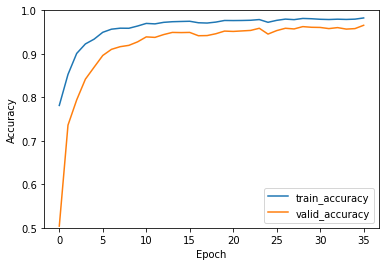

In [ ]:
# Train the model and save the history object


# Plot the training and validation accuracy graph
plt.plot(history.history['Accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'valid_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
model.save('./drive/MyDrive/BEProjectNew/LungCancer.h5')